In [1]:
from decimal import Decimal
import time 
import decimal
math = decimal.Context()
import numpy 
import random
%matplotlib inline
import matplotlib
import pandas

In [2]:
class Token:       
    def __init__(self, _name = ""):
        self.balances = {}
        self.totalSupply = 0
        self._name = _name
    
    def mint(self, address, amount):
        assert(amount > 0)
        self.balances[address] = self.balances.get(address, 0) + amount
        self.totalSupply += amount
        return True
        
    def burn(self, address, amount):
        assert(amount > 0)
        if self.balances[address] < amount:
            raise Exception("burn: Cannot burn more value than present at address. Requested: {} Available: {}".format(amount, self.balances[address]))
        self.balances[address] = self.balances.get(address, 0) - amount
        self.totalSupply -= amount
        return True
    
    def balanceOf(self, address):
        return self.balances.get(address, 0)
    
    def name(self):
        return self._name
    
    def transferFrom(self, sender, recipient, amount):
        assert(amount >= 0)
        # always round
        if self.balanceOf(sender) >= amount:
            self.balances[sender] = self.balances.get(sender, 0) - amount
            self.balances[recipient] = self.balances.get(recipient, 0) + amount    
            return True
        else:
            raise Exception("transferFrom: Cannot transfer more than balance")

In [3]:
# Basic test of Token class

token = Token()
token.mint("A", 5)
assert(token.balanceOf("A") == 5)

token.transferFrom("A", "B", 3)
assert(token.balanceOf("B") == 3)
assert(token.balanceOf("A") == 2)

token.transferFrom("A", "C", 2)
assert(token.balanceOf("A") == 0)
assert(token.balanceOf("C") == 2)

In [4]:
class blockchain:
    
    def __init__(self, _timestamp, _block):
        self.timestamp = _timestamp
        self.block = _block
    
    def incrementBlock(self):
        self.block += 1
        self.timestamp += 15
    
    def updateTimestamp(self, _timestamp):
        self.timestamp = _timestamp
    
    def now(self):
        return self.timestamp


class InterestToken(Token):
    # rate is a yearly rate, converted to a rate compounded per second
    def __init__(self, _name, _blockchain, rate, _rateAccumulator):
        Token.__init__(self, _name)
        self.blockchain = _blockchain
        self.lastUpdate = self.blockchain.now()
        self.rateAccumulator = _rateAccumulator
        # 31622400 is the number of seconds in a year
        self.rate = math.power(1 + Decimal(rate), 1/Decimal(31622400))  
        self.interestRateLimit = math.power(1 + Decimal(2), 1/Decimal(31622400)) 
    
    def balanceOfUnderlying(self, address):
        return self.balanceOf(address) * self.rateAccumulator
    
    def transferUnderlying(self, sender, recipient, amount):
        value = amount / self.rateAccumulator
        return self.transferFrom(sender, recipient, value)
    
    def totalSupplyUnderlying(self):
        return self.totalSupply * self.rateAccumulator
        
    def accrueInterest(self):
        now = self.blockchain.now()
        if now > self.lastUpdate:
            total_time =  now - self.lastUpdate
            self.rateAccumulator = math.power(self.rate, total_time) * self.rateAccumulator
            self.lastUpdate = now
    
    def updateRate(self, update):
        print("Using old updateRate for some reason!")
        newRate = math.power(1 + Decimal(update), 1/Decimal(31622400)) - 1
        self.rate = self.rate + newRate
        if self.rate < Decimal(1):
            self.rate = Decimal(1)
        if self.rate > self.interestRateLimit:
            self.rate = self.interestRateLimit
    
    def yearlyRate(self):
        return math.power(self.rate, Decimal(31622400)) - 1
    
    def mintInUnderlying(self, address, amount):
        return self.mint(address, amount/self.rateAccumulator)
        
    def burnInUnderlying(self, address, amount):
        return self.burn(address, amount/self.rateAccumulator)

In [5]:
# Basic tests of Interest Token Class

chain = blockchain(0,1)
token = InterestToken("Token", chain, .02, 1)
token.mint("A", 1000)
#token.lastUpdate = token.lastUpdate - 31622400
chain.updateTimestamp(31622400)
token.accrueInterest()
token.balanceOfUnderlying("A")
assert(int(token.balanceOfUnderlying("A")) == 1020)

In [6]:
chain = blockchain(0,1)
token = InterestToken("Token", chain, .02, 1)
token.mint("A", 1000)
#token.lastUpdate = token.lastUpdate - 31622400
# Note that the per second rates are multiplied, not added
token.updateRate(.001)
token.updateRate(.001)
token.updateRate(-.001)
token.updateRate(.001)
token.updateRate(.001)
#print(token.yearlyRate())
chain.updateTimestamp(31622400)
#print(token.rate)
token.accrueInterest()
assert(int(token.balanceOfUnderlying("A")) == 1023)

Using old updateRate for some reason!
Using old updateRate for some reason!
Using old updateRate for some reason!
Using old updateRate for some reason!
Using old updateRate for some reason!


In [7]:

# class QX:
#  mint(address, amount):
#  redeem(address, amount):
#   measureRatio(self)
#
class QX:
    def __init__(self, _uToken : Token , _sToken : Token):
        self.uToken = _uToken
        self.pyToken = _sToken
        self.underlying = Decimal('0')
        self.synthetic  = Decimal('0')   # denominated in pyTokens
        self.address = '0xQX_' + _uToken.name()
        self.book = dict()

    def mint(self, address, amount):
        if amount < 0:
            raise Exception("mint: Cannot sell a negative amount. Amount: {}".format(amount))
        result = self.uToken.transferFrom(address, self.address, amount)
        if result:
            self.underlying += amount
            result = self.pyToken.mintInUnderlying( self.address, amount)
            if not result:
                raise Exception("mint: Minting pyTokens failed. Amount: {}".format(amount))
            result = self.pyToken.transferUnderlying(self.address, address, amount)
            if not result:
                raise Exception("mint: Token transfer out failed. Amount: {}".format(amount))
        else:
            raise Exception("mint: Token transfer in failed. Amount: {}".format(amount))
    
    def redeem(self, address, amount):
        if amount < 0:
            raise Exception("redeem: Cannot redeem a negative amount. Amount: {}".format(amount))
        if self.underlying < amount:
            raise Exception("redeem: Cannot withdraw more than available in reserves")
        result = self.pyToken.burnInUnderlying(address, amount)
        if result:
            outResult = self.uToken.transferFrom(self.address, address, amount)
            if not outResult:
                raise Exception("redeem: Token transfer out failed")
            self.underlying -= amount
        else:
            raise Exception("redeem: Token transfer in failed. Amount: {}".format(amount))
    
    
    def measureRatio(self):
        try:
            if self.underlying <= 0:
                return Decimal('0')
            return Decimal(self.underlying) / Decimal(self.pyToken.getTotalDebt() + self.underlying)
        except Exception as e:
            print("underlying: {} TotalDebt:{}".format(self.underlying, self.pyToken.getTotalDebt()))
            raise e
    

In [8]:
class Oracle:
    def __init__(self, _tokenA, _tokenB):
        self.tokenA = _tokenA
        self.tokenB = _tokenB
        # Price is stored in terms of TokenB
        self.price = 0 
    
    # Assumes price is in terms of Token B
    def currentPrice(self):
        return self.price
    
    # Assumes price is in terms of Token B
    def setPrice(self, price):
        self.price = price
        
    def setPriceInToken(self, token, price):
        if token == self.tokenA:
            self.price = 1 / price
        else:
            self.price = price
            
    def getPriceInToken(self, token):
        if token == self.tokenA:
            return Decimal('1') /self.price
        else:     
            return self.price

In [9]:
# Simple Test of Oracle
ETH = Token("ETH")
DAI = Token("DAI")
oracle = Oracle(ETH, DAI)
oracle.setPriceInToken(DAI, Decimal('100'))
assert(oracle.getPriceInToken(DAI) == Decimal('100'))
assert(oracle.getPriceInToken(ETH) == (Decimal('1')/Decimal('100')))

In [10]:
# Issues:
# 1. it is possible to pay out more pyTokens that is offset by debt


class pyToken (InterestToken):
    def __init__(self, _blockchain, _underlying : Token, _oracle):  
        super().__init__("", _blockchain, Decimal('0'), Decimal('1'))
        self.underlying = _underlying
        self._name = "py" + self.underlying.name()
        self.cdp = {self.underlying.name(): {}}
        self.tokens = {}
        self.address = '0x' + self.name()
        # oracle for the pyToken <> pyToken pair
        self.oracle = _oracle
        self.qx = 0
        self.interestUpdateAmount = Decimal('0.0001')
        self.collateralizationRatio = Decimal('1.7')
        self.debtAccumulator = self.rateAccumulator
        self.debtRate = Decimal('1.0')
        # totalDebt is normalized by the debtAccumulator
        self.totalDebt = Decimal('0.0')
        # bonus factor when liquidating
        self.bonus = Decimal('1.1')
        self.reservesTarget = Decimal('0.3')
        self.adjustmentFreeWindow = Decimal('0.1')
        # minimumSpread may be deprecated
        self.minimumSpread = Decimal('0.1')
        self.borrowFee = Decimal('0.1')
        self.totalFeeIncome = Decimal('0.0')
        self.impliedRate = Decimal('1.0')
        self.blockchain = _blockchain
        
        
    # Admin Functions
    def setPair(self, _pairedpyToken : InterestToken):
        self.pairedpyToken = _pairedpyToken  
        self.tokens[self.pairedpyToken.name()] = self.pairedpyToken
        self.cdp[self.pairedpyToken.name()] = {}
        
    def setQueueExchange(self,exchange):
        self.qx = exchange
        
    def addCollateralType(self, token, oracle):
        self.tokens[token.name()] = { 'token':token, 'oracle':oracle }
        self.cdp[token.name()] = {}
    
    # User Functions
    def addCollateral(self, token, address, amount):
        if token not in self.tokens.keys():
            return False
        result = self.tokens[token]['token'].transferFrom(address, self.address, amount)
        if result:
            if address not in self.cdp[token]:
                self.cdp[token][address] = {'amount':amount, 'debt':Decimal('0')}
            else:
                self.cdp[token][address]['amount'] += amount
        else:
            return False
      
    def withdrawCollateral(self, token, address, amount):
        if token not in self.tokens.keys():
            return False
        # check oracle price
        price = self.oracle.currentPrice()
        minimumCollateral = self.oracle.currentPrice() * self.collateralizationRatio * \
                            (self.cdp[token][address]['debt'] * self.debtAccumulator - amount)
        if self.cdp[token][address]['amount'] < minimumCollateral:
            raise Exception("withdrawCollateral: Insufficient free capital to withdraw")
        result = self.tokens[token].transferFrom(self.address, address, amount)
        if result:
            self.cdp[token][address]['amount'] = self.cdp[token][address]['amount'] - amount
    
    # accrue for both debt and interest
    def accrueInterest(self):
        now = self.blockchain.now()
        if now > self.lastUpdate:
            total_time =  now - self.lastUpdate
            accumulatedDebtInterestMultiplier = math.power(self.debtRate, total_time)
            self.debtAccumulator = accumulatedDebtInterestMultiplier * self.debtAccumulator
            # pay interest out to hodlers
            newDebt = (accumulatedDebtInterestMultiplier - Decimal('1')) * (self.totalDebt * self.debtAccumulator)
            # self.rateAccumulator = math.power(self.rate, total_time) * self.rateAccumulator
            feeIncome = newDebt * self.borrowFee
            self.totalFeeIncome += feeIncome
            totalPyTokens = self.totalSupply * self.rateAccumulator
            if self.totalSupply > Decimal('0'):
                self.rateAccumulator = ((newDebt - feeIncome) + totalPyTokens)/self.totalSupply
                self.impliedRate = math.power(((newDebt - feeIncome) + totalPyTokens)/totalPyTokens, Decimal(1)/Decimal(total_time))
            else:
                self.rateAccumulator = Decimal('1')
            self.lastUpdate = now
    
    def yearlyRate(self):
        return math.power(self.impliedRate, Decimal(31622400)) - 1
    
    # updateRate for both debt and interest
    # this contract implicity assumes that this is called every block
    def updateRate(self, update):
        #newRate = math.power(1 + Decimal(update), 1/Decimal(31622400)) - 1
        newRate = math.power(1 + Decimal(update), 1/Decimal(31622400)) 
        self.debtRate = self.debtRate * newRate
        if self.debtRate < Decimal(1):
            self.debtRate = Decimal(1)
        if self.debtRate > self.interestRateLimit:
            self.debtRate = self.interestRateLimit
        if self.totalDebt == 0:
            print("Reseting Rates")
            self.debtRate = Decimal(1)
            self.rate = Decimal(1)
            return
        
        # To-DO:
        # Update rate to be equal to rate = (debt*debtRate - fees)/(debt + reserveRatioTarget * debt)
        
        #calculate pyToken rate. The "1" in the denominator is to avoid divide by zero. Can we do this better?
        #debt = self.getTotalDebt()
        #self.rate = Decimal(1) + ((self.debtRate-1) * debt - self.minimumSpread)/(1 + (debt + debt*self.reservesTarget))
        #if self.rate < Decimal(1):
        #    self.rate = Decimal(1)

    def yearlyDebtRate(self):
        return math.power(self.debtRate, Decimal(31622400)) - 1
    
    def getTotalDebt(self):
        return self.totalDebt * self.debtAccumulator
    
    def getCollateral(self, token, address):
        return self.cdp[token][address]['amount'] 
    
    def getDebt(self, token, address):
        return self.cdp[token][address]['debt'] 
    
    def debtInUnderlying(self, token, address):
        return self.cdp[token][address]['debt'] * self.debtAccumulator
    
    # borrow against a particular tokens worth of collateral
    def borrow(self, token, address, amount):
        if token not in self.tokens.keys():
            raise Exception("Borrow: Token not found")
        if amount < 0:
            raise Exception("Borrow: Cannot borrow negative amounts")
            self.tokens[token.name()] = { 'token':token, 'oracle':oracle }
        price = self.tokens[token]['oracle'].getPriceInToken(self.underlying)
        minimumCollateral = ( 1 / price) * self.collateralizationRatio * \
                            (self.cdp[token][address]['debt'] * self.debtAccumulator + amount)
        if self.cdp[token][address]['amount'] < minimumCollateral:
            raise Exception("Borrow: Insufficient collateral Available: {} Minimum Needed: {}".format(self.cdp[token][address]['amount'], minimumCollateral))
        # Add debt
        self.cdp[token][address]['debt'] = self.cdp[token][address]['debt'] + Decimal(amount) / self.debtAccumulator
        # Add borrow
        self.mintInUnderlying(address, amount)
        self.totalDebt += Decimal(amount) / self.debtAccumulator
        try:
            assert(self.balanceOfUnderlying(address) >= amount)
        except:     
            print("amount minted: {} balance: {}".format(amount, self.balanceOfUnderlying(address)))
        
    def maximumBorrow(self, token, address):
        price = self.tokens[token]['oracle'].getPriceInToken(self.underlying)
        maximumBorrow = self.cdp[token][address]['amount'] * price * \
                         (1 / self.collateralizationRatio) 
        return maximumBorrow
    

       
    def liquidate(self, token, addressToLiquidate, LiquidatorAddress, amount):
        price = self.tokens[token]['oracle'].getPriceInToken(self.underlying)
        maximumBorrow = self.maximumBorrow(token, addressToLiquidate)
        debt = self.debtInUnderlying(token, addressToLiquidate)
        if maximumBorrow < debt:
            # We need to liquidate
            if amount < debt:
                raise Exception("liquidate: Must liquidate entire CDP at once")
            availableFunds = self.balanceOfUnderlying(LiquidatorAddress)
            if availableFunds < amount:
                raise Exception("liquidate: Insufficient funds to liquidate")
            
            collateralToLiquidator = debt*self.bonus/price
            if collateralToLiquidator > self.cdp[token][addressToLiquidate]['amount']:
                raise Exception("liquidate: CDP liquidated while undercollateralized. Owed to Liquidator: {} Available: {}".format(collateralToLiquidator, self.cdp[token][addressToLiquidate]['amount']))
            # Only burn amount of debt--it's possible to specify more than debt and have liquidate succeed
            self.burn(LiquidatorAddress, self.getDebt(token, addressToLiquidate))
            # Transfer liquidated funds to Liquidator
            self.tokens[token]['token'].transferFrom(self.address, LiquidatorAddress, collateralToLiquidator)
            # Debit CDP account 
            self.cdp[token][addressToLiquidate]['amount'] -= collateralToLiquidator
            # Wipe Debt
            self.cdp[token][addressToLiquidate]['debt'] = 0
            self.totalDebt -= Decimal(amount) / self.debtAccumulator
        else:
            raise Exception("liquidate: Cannot liquidate a working CDP")
        
    # Position in a particular collateral token
    def position(self, token, address):
        return self.cdp[token][address]
    
    def repay(self, token, address, amount):
        if token not in self.tokens.keys():
            return False
        if amount < 0:
            return False        
        if amount > self.debtInUnderlying(token, address):
            raise Exception("repay: Cannot repay more than available debt")
        if amount > self.balanceOfUnderlying(address):
            raise Exception("repay: Must have sufficient funds to repay.")
        # Decrease debt
        result = self.burnInUnderlying(address, amount)
        if not result:
            raise Exception("repay: Burn Tokens failed")
        self.cdp[token][address]['debt'] = self.cdp[token][address]['debt'] - Decimal(amount) / self.debtAccumulator
        self.totalDebt -= Decimal(amount) / self.debtAccumulator
        assert(self.cdp[token][address]['debt'] >= 0)
        
    def updateRates(self):
        if self.totalSupply == 0:
            return
        imbalance = self.qx.measureRatio()    
        if imbalance > self.reservesTarget:
            # lower interest rate
            self.updateRate(-self.interestUpdateAmount)
        elif imbalance < self.reservesTarget - self.adjustmentFreeWindow:
            # raise interest rate
            self.updateRate(self.interestUpdateAmount)

        
        

In [11]:
debtRate = Decimal(1.1)
totalDebt = Decimal(1000)
minimumSpread = Decimal(.1)
totalSupply = Decimal(1000)

rate = Decimal(1) + ((debtRate-1) * totalDebt * (1 - minimumSpread))/(1 + totalSupply)
print(rate)
-Decimal('1')

1.089910089910089989391554706


Decimal('-1')

In [12]:
# Basic test of pyToken class

chain = blockchain(1,1)
BAT = Token("BAT")
DAI = Token("DAI")
oracleA = Oracle(BAT, DAI)

collateral = Token("Collateral")
oracleC = Oracle(collateral, BAT)
oracleC.setPrice(Decimal(1000000))
pyBAT = pyToken(chain, BAT, oracleA)
pyBAT.addCollateralType(collateral, oracleC)
qx = QX(BAT , pyBAT)
pyBAT.setQueueExchange(qx)

oracleC.setPrice(Decimal(1000))
BAT.mint("A", Decimal('1000'))
collateral.mint("B", Decimal('1000'))
pyBAT.addCollateral("Collateral", "B", Decimal('100'))
pyBAT.borrow("Collateral", "B", Decimal('10'))
pyBAT.repay("Collateral", "B", Decimal('10'))
pyBAT.borrow("Collateral", "B", Decimal('10'))
assert(pyBAT.balanceOf("B") == Decimal('10'))


In [13]:
# Liquidation Test
oracleC.getPriceInToken(collateral)
debt = pyBAT.debtInUnderlying("Collateral", "B")
maxBorrow = pyBAT.maximumBorrow("Collateral", "B")
pyBAT.borrow("Collateral", "B", maxBorrow-debt)
# Now make repo undercollateralized
oracleC.setPriceInToken(BAT, Decimal(900))
pyBAT.mint("A", Decimal('100000'))
pyBAT.liquidate("Collateral", "B", "A", pyBAT.debtInUnderlying("Collateral", "B"))
assert(pyBAT.debtInUnderlying("Collateral", "B") == Decimal('0'))
assert(collateral.balanceOf("A") == Decimal('71.89542483660130718954248367'))
assert(pyBAT.getCollateral("Collateral", "B") + collateral.balanceOf("A") == Decimal('100.0000000000000000000000000'))

In [14]:
# External market that provides "infinite" liquidity
class ReferenceExchange:
    def __init__(self):
        self.tokenPairs = {}
        self.address = "0xReferenceExchange"
    
    # Add pair. The price is the number of tokenB per tokenA
    def addPair(self, tokenA, tokenB):
        firstToken = tokenB.name()
        secondToken = tokenA.name()
        if tokenA.name() > tokenB.name():
            firstToken = tokenA.name()
            secondToken = tokenB.name()
        
        if firstToken not in self.tokenPairs.keys():
            self.tokenPairs[firstToken] = {secondToken: {}}
        self.tokenPairs[firstToken][secondToken] = {'Base':tokenA, 'Quote':tokenB, 'Price':Decimal('0')}  
        
        # mint a lot of tokens for both sides
        tokenA.mint(self.address, Decimal(1000000000))
        tokenB.mint(self.address, Decimal(1000000000))

    
    def updatePairPrice(self, tokenA, tokenB, price):
        firstToken = tokenB.name()
        secondToken = tokenA.name()
        if tokenA.name() > tokenB.name():
            firstToken = tokenA.name()
            secondToken = tokenB.name()
        self.tokenPairs[firstToken][secondToken]['Price'] = price
    
    def trade(self, tokenA, tokenB, tokenAAmount, address):
        # transfer in tokenA
        result = tokenA.transferFrom(address, self.address, tokenAAmount)
        if result: 
            firstToken = tokenB.name()
            secondToken = tokenA.name()
            if tokenA.name() > tokenB.name():
                firstToken = tokenA.name()
                secondToken = tokenB.name()
            pair = self.tokenPairs[firstToken][secondToken]
            multiplier = 0
            if pair['Quote'].name() == tokenB.name():
                multiplier = pair['Price']
            else:
                multiplier = 1/pair['Price']
            # calculate amount of tokenB to send
            tokens_to_send = tokenAAmount * multiplier
            # send tokenB to address
            transferR = tokenB.transferFrom(self.address, address, tokens_to_send)
            return (tokens_to_send, transferR)
        else:
            raise Exception("Trade: Token transfer failed")

In [15]:
class Interface:
    
    def __init__(self, _chain : blockchain, _uTokenA : Token, _uTokenB : Token, oracle):
        self.A = _uTokenA
        self.B = _uTokenB
        self.chain = _chain
        self.oracle = oracle
        self.pyA = pyToken(_chain, self.A, oracle)
        self.pyB = pyToken(_chain, self.B, oracle)
        self.pyA.setPair(self.pyB)
        self.pyB.setPair(self.pyA)
        self.qxA = QX(self.A , self.pyA)
        self.qxB = QX(self.B , self.pyB)
        self.pyA.setQueueExchange(self.qxA)
        self.pyB.setQueueExchange(self.qxB)
        # Add "ETH" as acceptable collateral
        self.eth = Token("ETH")
        self.ethAOracle = Oracle(self.eth, self.A)
        self.ethBOracle = Oracle(self.eth, self.B)
        self.ethAOracle.setPrice(Decimal('100'))
        self.ethBOracle.setPrice(Decimal(100/oracle.currentPrice()))
        self.pyA.addCollateralType(self.eth, self.ethAOracle)
        self.pyB.addCollateralType(self.eth, self.ethBOracle)
        self.ref = ReferenceExchange()
        self.ref.addPair(self.eth, self.A)
        self.ref.updatePairPrice(self.eth, self.A, self.ethAOracle.currentPrice())
        self.ref.addPair(self.eth, self.B)
        self.ref.updatePairPrice(self.eth, self.B, self.ethBOracle.currentPrice())
        
    def updateInterestRates(self):
        self.pyA.updateRates()
        self.pyB.updateRates()
        self.pyA.accrueInterest()
        self.pyB.accrueInterest()
    
    def eachBlock(self):
        self.chain.incrementBlock()
        self.updateInterestRates()
        
        
        


## Agents

In [16]:
class Agent:
    def __init__(self, _interface):
        self.interface = _interface
        self.address = numpy.random.randint(1,1000)
        
    def setup(self):
        pass
    
    def performActions(self):
        pass
    
    def shutdown(self):
        pass
    

class YieldAgent(Agent):
    def __init__(self, _interface):
        super().__init__(_interface)
        self.address = "0xYA_HodlPY" + str(self.address)
        self.block = 0
        
    def setup(self):   
        self.initialA = min(Decimal(round(numpy.random.lognormal(6, 1))), Decimal(1000))
        self.initialB = min(Decimal(round(numpy.random.lognormal(6, 1))), Decimal(1000))
        #self.initialA =  Decimal(1000000000)
        #self.initialB =  Decimal(1000000000)
        self.interface.A.mint(self.address, Decimal(self.initialA))
        self.interface.B.mint(self.address, Decimal(self.initialB))
        self.initial_exchange_rate = self.interface.oracle.currentPrice()
        self.lowerRate = Decimal(numpy.random.uniform(0,7) / 100)
        self.upperRate = self.lowerRate + Decimal(numpy.random.uniform(0,5) / 100)
    
    def performActions(self):
        if self.interface.pyA.yearlyRate() > self.upperRate:
            self.HODL()
        elif self.interface.pyA.yearlyRate() < self.lowerRate:
            self.unHODL()
            
    def HODL(self):
        self.block = self.interface.chain.block
        if self.interface.A.balanceOf(self.address) > 0:
            aBalance = self.interface.A.balanceOf(self.address)
            self.interface.qxA.mint(self.address, aBalance)
            print("HODLing {} tokens at rate {}".format(aBalance, round(self.upperRate, 4)))
            
    def unHODL(self):
        if self.block - self.interface.chain.block < 10:
            return
        amount = min(self.interface.pyA.balanceOfUnderlying(self.address), self.interface.qxA.underlying)
        amount = amount*Decimal('0.1')
        if amount > 0:
            # let's only remove 10% at a time
            self.interface.qxA.redeem(self.address, amount)
            print("unHODLing {} tokens".format(amount*Decimal('0.99'), round(self.lowerRate, 4)))
            
            
# Borrow agents lever up on ETH collateral by selling pyTokens
class BorrowAgent(Agent):
    def __init__(self, _interface):
        super().__init__(_interface)
        self.address = "0xBA_longETH" + str(self.address)
        
    def setup(self):
        self.initialETH = min(Decimal(round(numpy.random.lognormal(3, 1))), Decimal(100))
        self.interface.eth.mint(self.address, Decimal(self.initialETH ))
        ethReserve = self.initialETH * Decimal('0.1')
        self.each = (self.initialETH - ethReserve)/2
        self.interface.pyA.addCollateral("ETH", self.address, self.each )
        self.interface.pyB.addCollateral("ETH", self.address, self.each )
        price = self.interface.ethAOracle.getPriceInToken(self.interface.A)
        self.desiredBorrow = Decimal('0.5')*self.interface.pyA.maximumBorrow("ETH", self.address)
        self.interface.A.mint(self.address, self.desiredBorrow*1000)
        self.lowerRate = Decimal(numpy.random.uniform(0,10) / 100)
        self.upperRate = self.lowerRate + Decimal(numpy.random.uniform(0,5) / 100)
    
    def performActions(self):
        if self.interface.pyA.yearlyDebtRate() > self.upperRate:
            self.unBorrow()
        elif self.interface.pyA.yearlyDebtRate() < self.lowerRate:
            self.borrow()
        uAmount = min(self.interface.pyA.balanceOfUnderlying(self.address), self.interface.qxA.underlying)
        if uAmount > Decimal('0.1'):
            self.interface.qxA.redeem(self.address, uAmount*Decimal(.99))
            print("Withdrew {} tokens at {}".format(round(uAmount*Decimal(.99), 4), round(self.lowerRate, 4) ))
            
            
    def borrow(self):
        price = self.interface.ethAOracle.getPriceInToken(self.interface.A)
        #if we've already mostly borrowed what we desire, let's stop
        if self.interface.pyA.debtInUnderlying("ETH", self.address) > Decimal('.99') * self.desiredBorrow:
            return
        #initiate borrow
        borrowRatio = Decimal('0.5')
        amount = self.interface.pyA.maximumBorrow("ETH", self.address) - self.interface.pyA.debtInUnderlying("ETH", self.address)
        borrow = (amount * borrowRatio) / (self.interface.pyA.collateralizationRatio )
        if borrow > Decimal('0.1'):
            self.interface.pyA.borrow("ETH", self.address, borrow)
            print("Borrowed {} tokens at {}".format(round(borrow, 4), round(self.lowerRate, 4) ))

    
    def unBorrow(self):
        amount = Decimal('0.95') * self.interface.pyA.debtInUnderlying("ETH", self.address)
        #funds = self.interface.A.balanceOf(self.address)
        #toUnBorrow = min(debt, funds)
        if amount > Decimal('0.1'):
            try:
                self.interface.qxA.mint(self.address, amount*Decimal(1.01))
                self.interface.pyA.repay("ETH", self.address, amount)
                print("unBorrowed {} tokens at {}".format(round(amount, 4), round(self.upperRate, 4) ))
            except Exception as e: 
                print("failed to unborrow. amount:{} underlying balance: {} pyTokens: {} ".format(amount, self.interface.A.balanceOf(self.address), self.interface.pyA.balanceOfUnderlying(self.address)))
                raise e
    


In [169]:
import numpy

chain = blockchain(1,1)
oracle.setPrice(Decimal('2'))
tokenA = Token("TokenA")
tokenB = Token("TokenB")
oracle = Oracle(tokenA, tokenB)
oracle.setPrice(Decimal('1'))
interface = Interface(chain, tokenA, tokenB, oracle)

interface.pyA.interestUpdateAmount = Decimal('0.0001')
interface.pyA.reservesTarget = Decimal('0.25')
interface.pyA.minimumSpread = Decimal('0.0')
interface.pyA.adjustmentFreeWindow = Decimal('0.01')

# tracking variables
pyAinterest = []
pyBinterest = []
qxA = []
qxB = []
pyratesA = []
debtratesA = []
tSupply = []
ulying = []
debtOutstanding = []
debtSupplyRatio = []
feeIncome = []
rrMean = []
rrvar  = []
reservesTarget = []
candidateReserves = []



# Initial positions
interface.A.mint("HODL", Decimal(100000))
interface.B.mint("HODL", Decimal(100000))
interface.eth.mint("BU", Decimal(1000))
interface.pyA.addCollateral("ETH", "BU", Decimal(100) )
interface.pyB.addCollateral("ETH", "BU", Decimal(100) )

price = interface.ethAOracle.getPriceInToken(interface.A)
#borrow = (Decimal(25) * price) / (interface.pyA.collateralizationRatio )
#borrow = Decimal(100)
#interface.pyA.borrow("ETH", "BU", borrow)
#interface.qxA.mint("HODL", Decimal(1500 * 0.15))

#Create users

#user1 = YieldAgent(interface)
#user2 = BorrowAgent(interface)
#users = [user1, user2]

users = []
for x in range(5):
    users.append(YieldAgent(interface))
    
for y in range(2):
    users.append(BorrowAgent(interface))

# Setup
for user in users:
    user.setup()

    
mean_estimate = Decimal(0)  
measurements = Decimal(0) 
var_estimate = Decimal(0)
lastReserves = Decimal(0)
measurementsLimit = Decimal(15)

# Run
for block in range(4000):
    
    # skip some blocks
    #if numpy.random.uniform(0,100) < 80:
    #    continue
    
    # perform interest rate update at beginning of block
    interface.eachBlock()
    
    # add users
    if numpy.random.uniform(0,100) < 4:
        if numpy.random.uniform(0,100) < 33:
            newAgent = BorrowAgent(interface)
            newAgent.setup()
            users.append(newAgent)
        else:
            newAgent = YieldAgent(interface)
            newAgent.setup()
            users.append(newAgent)
    
    for user in users:
        user.performActions()
    
    #calculate an estimate of the reserves
    reserves = interface.qxA.underlying
    RTarget = (interface.pyA.totalDebt+interface.qxA.underlying)*interface.pyA.reservesTarget
    
    if reserves != lastReserves:
        if measurements !=0:
            mean_estimate = (1/measurements) * (reserves) + ((measurements - 1)/measurements) * mean_estimate
            var_estimate = (1/measurements) * math.ln((RTarget - reserves)**2) + ((measurements - 1)/measurements) * mean_estimate
        else:
            mean_estimate = Decimal(reserves)
            var_estimate = 0

        measurements += 1
        if measurements > measurementsLimit:
            measurements = Decimal(measurementsLimit)
        
    lastReserves = reserves 
    #Candidate new reserves Target
    candidateR = Decimal(10)*math.sqrt(interface.pyA.totalDebt)/(interface.pyA.totalDebt+interface.qxA.underlying)
    interface.pyA.reservesTarget = candidateR
    
    candidateReserves.append(float(candidateR))
    reservesTarget.append(float(RTarget))
    rrMean.append(float(mean_estimate))
    rrvar.append(float(var_estimate))
    pyAinterest.append(float(interface.pyA.yearlyRate()))
    debtSupplyRatio.append(float(interface.pyA.totalDebt/interface.pyA.totalSupply))
    qxA.append(float(interface.qxA.measureRatio()))
    debtOutstanding.append(float(interface.pyA.getTotalDebt()))
    pyratesA.append(float(interface.pyA.yearlyRate()))
    debtratesA.append(float(interface.pyA.yearlyDebtRate()))
    tSupply.append(float(interface.pyA.totalSupply))
    ulying.append(float(interface.qxA.underlying))
    feeIncome.append(float(interface.pyA.totalFeeIncome))
# Shutdown
for user in users:
    user.shutdown()

Borrowed 54.4983 tokens at 0.0688
Borrowed 85.6401 tokens at 0.0663
Borrowed 38.4694 tokens at 0.0688
Borrowed 60.4519 tokens at 0.0663
Borrowed 132.3529 tokens at 0.0697
Borrowed 93.4256 tokens at 0.0697
Borrowed 171.2803 tokens at 0.0648
Borrowed 120.9037 tokens at 0.0648
Borrowed 108.9965 tokens at 0.0749
Borrowed 76.9387 tokens at 0.0749
HODLing 1000 tokens at rate 0.0092
Withdrew 92.0380 tokens at 0.0688
Withdrew 144.6312 tokens at 0.0663
Withdrew 223.5209 tokens at 0.0697
Withdrew 289.2623 tokens at 0.0648
Withdrew 184.0760 tokens at 0.0749
Withdrew 0.9204 tokens at 0.0688
Withdrew 1.4463 tokens at 0.0663
Withdrew 2.2352 tokens at 0.0697
Withdrew 2.8926 tokens at 0.0648
Withdrew 1.8408 tokens at 0.0749
Borrowed 155.7093 tokens at 0.0738
Withdrew 56.5649 tokens at 0.0738
Borrowed 109.9125 tokens at 0.0738
Withdrew 0.5656 tokens at 0.0738
Borrowed 700.6920 tokens at 0.0973
Borrowed 494.6061 tokens at 0.0973
Borrowed 607.2664 tokens at 0.0811
Borrowed 428.6587 tokens at 0.0811
Borro

unBorrowed 1293.9451 tokens at 0.0617
Withdrew 12.8638 tokens at 0.0614
Withdrew 0.1286 tokens at 0.0614
Borrowed 758.5166 tokens at 0.0614
Withdrew 750.9327 tokens at 0.0614
Borrowed 535.4235 tokens at 0.0614
Withdrew 537.5786 tokens at 0.0614
Withdrew 5.3758 tokens at 0.0614
unBorrowed 1293.9405 tokens at 0.0617
Withdrew 12.8638 tokens at 0.0614
Withdrew 0.1286 tokens at 0.0614
HODLing 390 tokens at rate 0.0346
Borrowed 758.5167 tokens at 0.0614
Withdrew 750.9328 tokens at 0.0614
Borrowed 535.4235 tokens at 0.0614
Withdrew 537.5786 tokens at 0.0614
Withdrew 5.3758 tokens at 0.0614
Borrowed 98.9149 tokens at 0.0541
Withdrew 97.9396 tokens at 0.0541
Withdrew 0.9794 tokens at 0.0541
HODLing 1000 tokens at rate 0.0349
Borrowed 132.3446 tokens at 0.0451
Withdrew 131.0278 tokens at 0.0451
Borrowed 93.4197 tokens at 0.0451
Withdrew 93.7958 tokens at 0.0451
Withdrew 0.9380 tokens at 0.0451
Borrowed 225.7785 tokens at 0.0446
Withdrew 223.5208 tokens at 0.0446
Borrowed 159.3731 tokens at 0.044

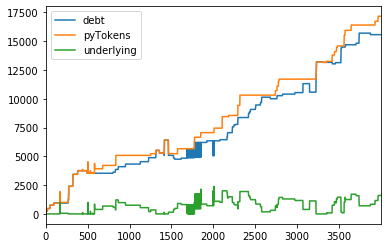

In [170]:
pandas.Series(debtOutstanding, name="debt").plot(legend=True)
pandas.Series(tSupply, name="pyTokens").plot(legend=True)
pandas.Series(ulying, name="underlying").plot(legend=True)

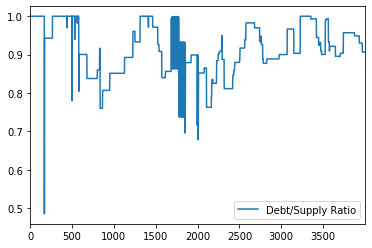

In [171]:
pandas.Series(debtSupplyRatio, name="Debt/Supply Ratio").plot(legend=True)

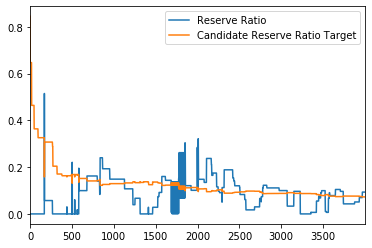

In [172]:
pandas.Series(qxA, name="Reserve Ratio").plot(legend=True)
pandas.Series(candidateReserves, name="Candidate Reserve Ratio Target").plot(legend=True)


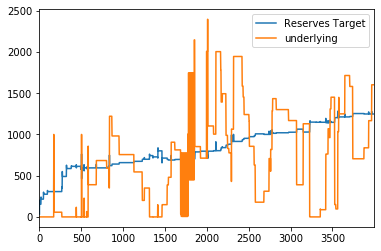

In [173]:
#pandas.Series(rrMean, name="Reserve Ratio Mean Estimate").plot(legend=True)
pandas.Series(reservesTarget, name="Reserves Target").plot(legend=True)
pandas.Series(ulying, name="underlying").plot(legend=True)

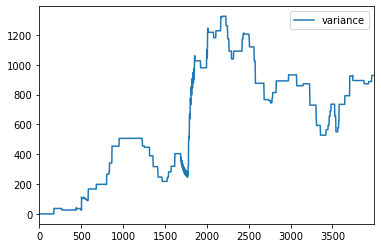

In [174]:
pandas.Series(rrvar, name="variance").plot(legend=True)

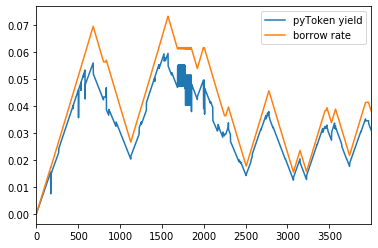

In [175]:
pandas.Series(pyratesA, name="pyToken yield").plot(legend=True)
pandas.Series(debtratesA,name="borrow rate").plot(legend=True)

In [22]:
# let's look at variance
pandas.Series(pyratesA[1000:], name="pyToken yield").var()

1.2647326092547395e-05

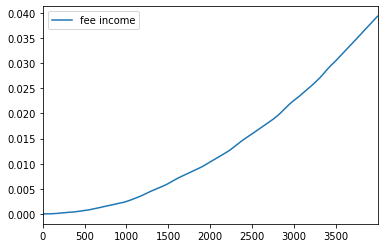

In [168]:
pandas.Series(feeIncome,name="fee income").plot(legend=True)

# Scratchpad

In [24]:
interface.A.balances

{'0xReferenceExchange': Decimal('1000000000'),
 'HODL': Decimal('100000'),
 '0xYA_HodlPY255': Decimal('239'),
 '0xYA_HodlPY312': Decimal('0'),
 '0xYA_HodlPY536': Decimal('530'),
 '0xYA_HodlPY753': Decimal('1000'),
 '0xYA_HodlPY539': Decimal('1000'),
 '0xBA_longETH202': Decimal('145588.1662439447303715612890'),
 '0xBA_longETH95': Decimal('1324857.494250996192092001421'),
 '0xYA_HodlPY342': Decimal('239'),
 '0xYA_HodlPY692': Decimal('0'),
 '0xYA_HodlPY187': Decimal('0'),
 '0xYA_HodlPY495': Decimal('0'),
 '0xQX_TokenA': Decimal('2180.551225007945549087069973'),
 '0xBA_longETH591': Decimal('145588.1628584547339975374692'),
 '0xYA_HodlPY403': Decimal('559'),
 '0xYA_HodlPY994': Decimal('572'),
 '0xYA_HodlPY506': Decimal('797'),
 '0xBA_longETH5': Decimal('39705.88235294117647058823530'),
 '0xBA_longETH215': Decimal('304717.2033041883467945107796'),
 '0xBA_longETH408': Decimal('119237.1649376913980946244718'),
 '0xBA_longETH633': Decimal('304411.7647058823529411764706'),
 '0xYA_HodlPY488': Dec

In [25]:
interface.pyA.balances

{'0xBA_longETH202': Decimal('0.0868882457381374672547674163'),
 '0xBA_longETH95': Decimal('0.028326767708364589296749430'),
 '0xQX_TokenA': Decimal('0E-25'),
 '0xYA_HodlPY312': Decimal('999.9996584443820805767014771'),
 '0xBA_longETH591': Decimal('0.0868430408615332689461752574'),
 '0xBA_longETH215': Decimal('0.026593795272738221944147451'),
 '0xBA_longETH408': Decimal('0.011952957666731207748354779'),
 '0xYA_HodlPY495': Decimal('611.9986997883756845181540008'),
 '0xYA_HodlPY692': Decimal('327.9989597152214036079218273'),
 '0xYA_HodlPY187': Decimal('1095.987359143417690977534448'),
 '0xBA_longETH820': Decimal('0.0044587566004282398784045651'),
 '0xYA_HodlPY251': Decimal('455.9972719665310129213045212'),
 '0xYA_HodlPY92': Decimal('153.9987284446132739195070753'),
 '0xYA_HodlPY35': Decimal('200.9982688959080735510379511'),
 '0xBA_longETH636': Decimal('0.0094748115885531628893651249'),
 '0xYA_HodlPY512': Decimal('128.9986138534116180282285082'),
 '0xYA_HodlPY347': Decimal('77.999145014857

In [26]:
numpy.random.lognormal(5, 1)

192.8080100478424

In [27]:
def lnmean(mean, sigma):
    sum = 0
    for x in range(1000):
        sum += numpy.random.lognormal(mean, sigma)
    return sum/1000

In [28]:
lnmean(.1,2)

12.910013808703923

In [29]:
lnmean(6,1)

650.4594621904588

In [30]:
def threshold(mean, sigma, limit ):
    result = int(numpy.random.exponential(mean))
    print(result)
    return result

In [31]:
def tfreq(mean, sigma, limit):
    sum = 0
    for x in range(100):
        if threshold(mean, sigma, limit ):
            sum += 1
    return sum

In [32]:
numpy.random.exponential(1)

1.3624386683879848

In [48]:
[1]*5

[1, 1, 1, 1, 1]

## Interest Tests

In [33]:
# self.rate = Decimal(1) + ((self.debtRate-1) * self.totalDebt * (1 - self.minimumSpread))/(1 + self.totalSupply)
# self.rate = math.power(1 + Decimal(rate), 1/Decimal(31622400)) 

In [34]:
from decimal import Decimal
import decimal
debtRate = Decimal('1.04')

In [35]:
math = decimal.Context()
accumulate = math.power(debtRate, 2)
accumulate

Decimal('1.0816')

In [36]:
minSpread = Decimal('0.00')
totalSupply = 1000
totalDebt = totalSupply * Decimal('0.7')

In [37]:
rate = Decimal(1) + ((debtRate-1) * totalDebt * (1 - minSpread))/(totalSupply)
#rate = ((debtRate) * totalDebt * (1 - minSpread))/(1 + totalSupply)

In [38]:
rate

Decimal('1.02800')

In [39]:
math.power(rate, 2)

Decimal('1.0567840000')

In [40]:
accumulate*totalDebt - totalDebt

Decimal('57.12000')

In [41]:
totalSupply*math.power(rate, 2) - totalSupply

Decimal('56.7840000000')

In [42]:
print(totalDebt*math.power(debtRate, 10))
print(totalSupply*math.power(Decimal('1.02'), 10))

1036.170999442840748032000
1218.99441999475713024000


In [43]:
interestUpdateAmount = Decimal('0.0001')
newRate = math.power(1 + Decimal(interestUpdateAmount), 1/Decimal(31622400))
newRate

Decimal('1.000000000003162157215564487')

In [44]:
1000000000003162157215564487 / 10**27

1.0000000000031621

In [45]:
(3162157215564487 * 90010) + 10**27


1000000284625770972959474870

In [46]:
2*10**27

2000000000000000000000000000

In [47]:
4.999999999999998706
4.999999999999999000

4.999999999999999